# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.


### Общее описание решения
При анализе данных, первое что бросается в глаза это дисбаланс классов.
Первое желание было сгенерировать с помощью аугментации доподнительные данные используя популярные библиотеки (например albumentations).
Идея была в увеличении самого датасета за счет генерации аугментированных изображений таким образом, чтобы в тренировочном датасете для каждого класса было не менее например по 1000 примеров.
Однако при дальнейшем изучении вопроса вяснилось, что подход в корне другой:
1. Подсчитываем кол-во данных для каждого класса через Counter 
2. Определяем для каждого класса его вес (1/кол-во сэмплов класса). Используя WeightedRandomSampler формируем сэмплер, который будет выдавать уравновешенное распределение данных по классам.
3. Чтобы разнообразить данные по "редким" классам (где мало данных) испоьлзуем аугментацию. По сути аугментация и трансформация делается на лету, т.е. при использовании даталоудера запрашиваем данные согласно нашему сэмплеру (грубо говоря по правилам которые опредлены сэмплере).

Плюс такого подхода в простоте реализации. Минус в том что аугментация на лету делается для всех классов, в том числе для которых достаточный объем обучающих данных, по хорошему для таких классов надо использовать оригинальные данные без аугментации.



Дополнительно относительно базовой модели добавлена батчнормализация в каждом слое

Импортируем необходимые библиотеки

In [3]:
from multiprocessing.pool import ThreadPool
from pathlib import Path

import numpy as np
import pandas as pd
from collections import Counter

import PIL
from PIL import Image
import pickle

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data.sampler import WeightedRandomSampler
import torchvision
from torchvision import transforms


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from skimage import io

from tqdm import tqdm, tqdm_notebook

from matplotlib import colors, pyplot as plt
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


Определяем наличие поддержки GPU

In [4]:
# !nvidia-smi
torch.cuda.is_available()
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    # работаем на процессоре
    print('CUDA не доступна.  Работаем на CPU ...')
    DEVICE = torch.device("cpu")    
else:
    # работаем на видеокарте
    print('CUDA доступна! Работаем на GPU ...')
    DEVICE = torch.device("cuda")

CUDA доступна! Работаем на GPU ...


Объявляем константы и пути

In [6]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
PATH = "simpsons_datasets/"
# PATH = "gdrive/MyDrive/DLS/simpsons/"
TRAIN_DIR = Path(PATH+'train_dataset')
TEST_DIR = Path(PATH+'test_dataset')


Загружаем данные

In [7]:
# загрузка данных
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [8]:
# np.random.randint(70,100)/100
# import random
# random.randrange(7,1)

Определяем класс SimpsonsDataset (наследуем от Dataset).
В классе SimpsonsDataset определяем необходмые процедуры по загрузке и предобработке данных. Аугментация производится именно здесь для каждого запрошенного объекта.

In [74]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.mode == "train": 
            min_random_rescale_size = int(RESCALE_SIZE*np.random.randint(8,10)/10)
            max_random_rescale_size = int(RESCALE_SIZE*np.random.randint(10,14)/10)
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                transforms.RandomChoice([
                    transforms.Resize(size=min_random_rescale_size, max_size=min_random_rescale_size+1),
                    transforms.Resize(size=max_random_rescale_size, max_size=max_random_rescale_size+1),
                ]),
                transforms.CenterCrop(size=RESCALE_SIZE),
                transforms.RandomCrop(RESCALE_SIZE),
                transforms.RandomRotation(degrees=(-25, 25)),
                transforms.RandomHorizontalFlip(p=0.5),  
            ])
        else:        
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ])
        
        
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        # x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

Определяем методы по визуализации данных. 
Обычный метод визуализации загруженных изображений и визуализации изображений в виде тензоров

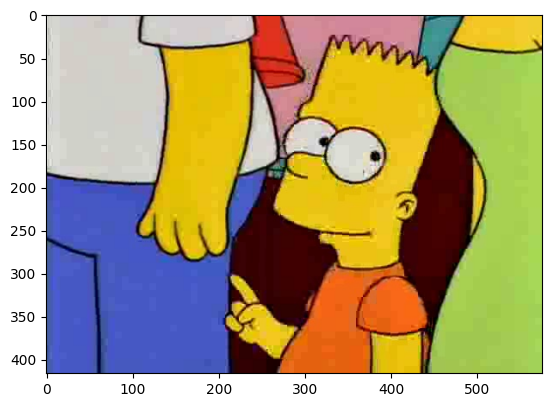

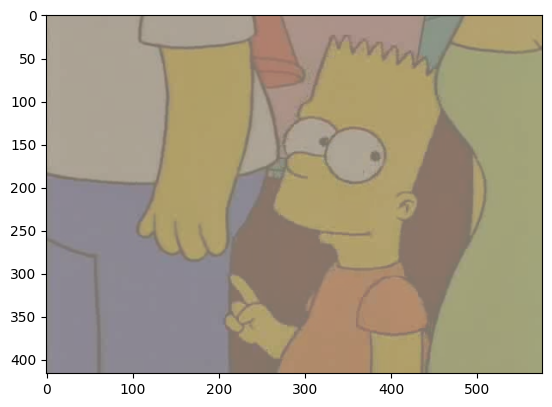

In [40]:
def visualize(image):
    """ Метод визуализации изображения"""
    plt.figure()
    plt.imshow(image)
    return plt

def visualize_tensor(inp):
    """
    Метод визуализации для тензоров
    При переводе в тензор каналы цветов перемещены на первую позицию, 
    а при обычной загрузке каналы цветов расположены в конце.
    Поэтому перед визуализацией делается доп. преобразование
    """
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure()
    plt.imshow(inp)

def imshow(inp, title=None, plt_ax=plt, default=False, to_hwc=True):
    """Imshow метод визуализации для тензоров с нормализацией. Метод взят из бейзлайна"""
#     print(inp.shape)
    inp = inp.numpy()
    if to_hwc:
        inp = inp.transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
#     plt.figure()
    plt_ax.imshow(inp)
    plt.rc('font', size=10) 
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)
    return None
    
image = Image.open(train_val_files[2000])
image.load()

visualize(image)
visualize_tensor(transforms.ToTensor()(image))
imshow(transforms.ToTensor()(image))

### Подготовливаем данные

Из тренировочных данных выделяем валидационные данные

In [29]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [30]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

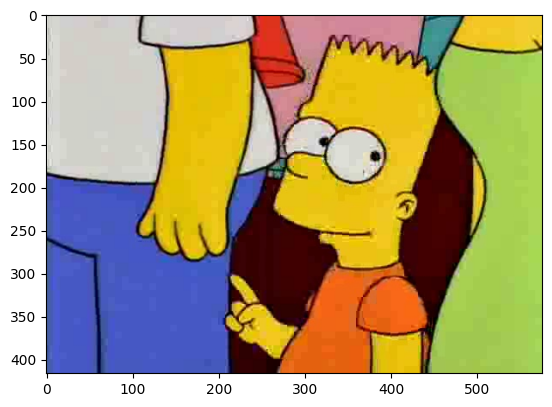

In [31]:
import PIL
from PIL import Image
import pickle

train_val_files[2000]
image = Image.open("simpsons_datasets/train_dataset/bart_simpson/pic_0316.jpg")
image.load()
transforms.ToTensor()(image)
imshow(transforms.ToTensor()(image))

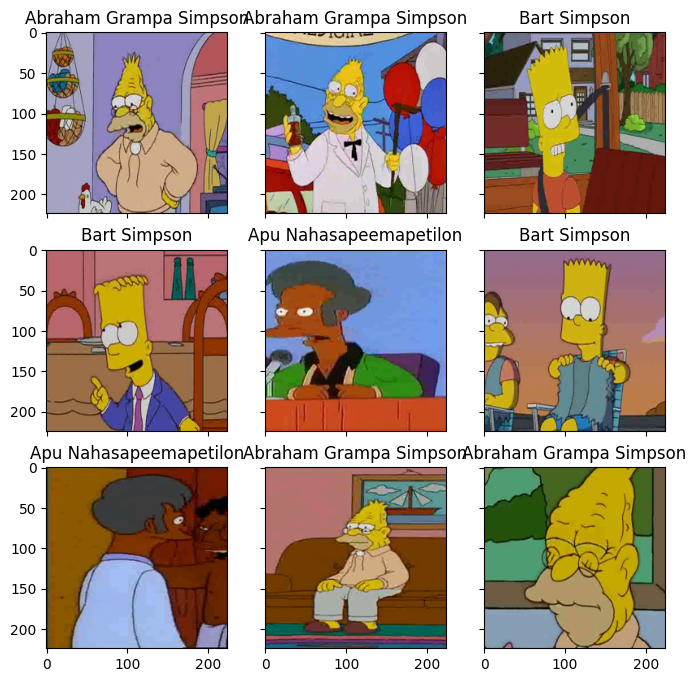

In [214]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val, \
          title=img_label,plt_ax=fig_x)

Проверка загруженных данных

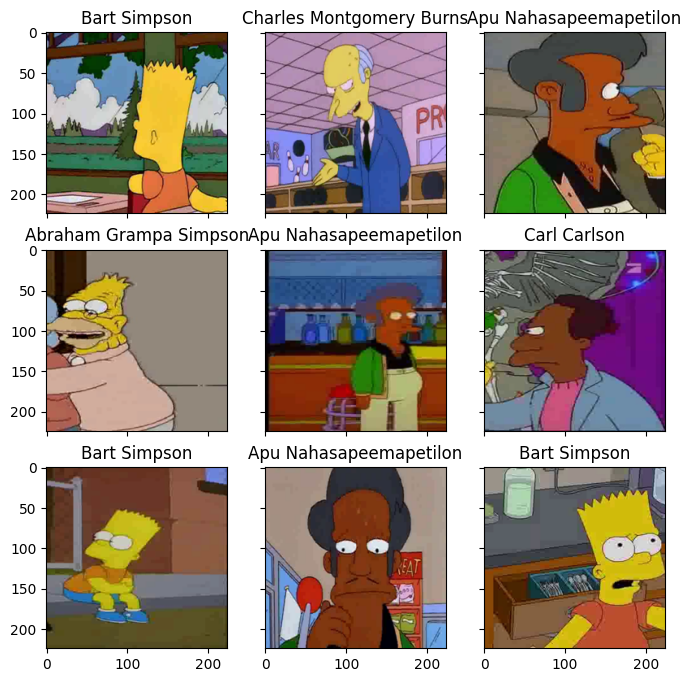

In [41]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val, \
          title=img_label,plt_ax=fig_x)
plt.show()

### Построение модели

Сама модель:
1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5

На каждом конв-слое добавлена батчнормализация.
В качестве активации используется LeakyReLU

In [42]:
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.LeakyReLU(),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.LeakyReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.LeakyReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.LeakyReLU(),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(kernel_size=2)
        )
#         self.drop_out = nn.Dropout(p=0.3)
#         self.fl_1 = nn.Linear(96 * 5 * 5, 1000)
#         self.out = nn.Linear(1000, n_classes)
        self.out = nn.Linear(96 * 5 * 5, n_classes)
        
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
#         x = self.fl_1(self.drop_out(x))
#         logits = self.out(self.drop_out(x))
        logits = self.out(x)
        return logits

Обучение модели на тренировочных данных

In [71]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in tqdm(train_loader, position = 0, leave=True):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
        
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

Прогон модели на валидационных данных

In [44]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

С целью борьбы с дисбалансом классов изменяется сэмплер DataLoader.

Метод для формивраония правила выборки данных (сэмплеров) на основе WeightedRandomSampler

In [45]:
# Формируем распределение данных для выгрузки из DataLoader сбалансированных данных
def create_sampler(ds):
    print(len(ds))
    class_count = Counter(ds.labels)
    class_weights = {name: 1/cnt for name, cnt in class_count.items()}

    sample_weights = [0] * len(ds)
    for i, label in enumerate(ds.labels):
        class_weight = class_weights[label]
        sample_weights[i] = class_weight
    # Максимальное кол-во объкетов = максимальное кол-во записей среди всех классов в трейне * на кол-во классов  
    N_count = max(class_count.values()) * len(class_count)

    sampler = WeightedRandomSampler(sample_weights, num_samples=N_count, replacement=True)
    return sampler

Главный цикл обучения по эпохам

In [46]:
def train(train_dataset, val_dataset, model, epochs, batch_size):
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=create_sampler(train_dataset))
    val_loader = DataLoader(val_dataset, batch_size=batch_size, sampler=create_sampler(val_dataset))
    
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

Предиктовый метод для предсказаний по тестовым данным

In [47]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

Итоговая структура модели

In [48]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify: {}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(

In [76]:
# Модель
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=4, batch_size=128)

15699
5234


100%|██████████| 553/553 [14:51<00:00,  1.61s/it]


loss 0.22549877361182835


epoch:  17%|█▋        | 1/6 [18:04<1:30:24, 1084.89s/it]


Epoch 001 train_loss: 0.2255     val_loss 2.0216 train_acc 0.9382 val_acc 0.7245


100%|██████████| 553/553 [14:03<00:00,  1.52s/it]


loss 0.19501907958486558


epoch:  33%|███▎      | 2/6 [34:21<1:08:04, 1021.09s/it]


Epoch 002 train_loss: 0.1950     val_loss 2.1975 train_acc 0.9464 val_acc 0.7363


100%|██████████| 553/553 [13:53<00:00,  1.51s/it]


loss 0.16636551147691941


epoch:  50%|█████     | 3/6 [50:21<49:39, 993.17s/it]   


Epoch 003 train_loss: 0.1664     val_loss 1.9846 train_acc 0.9520 val_acc 0.7406


100%|██████████| 553/553 [13:53<00:00,  1.51s/it]


loss 0.14623906225397526


epoch:  67%|██████▋   | 4/6 [1:06:18<32:37, 978.92s/it]


Epoch 004 train_loss: 0.1462     val_loss 2.0463 train_acc 0.9580 val_acc 0.7406


100%|██████████| 553/553 [14:03<00:00,  1.53s/it]


loss 0.14441251294966967


epoch:  83%|████████▎ | 5/6 [1:22:30<16:16, 976.63s/it]


Epoch 005 train_loss: 0.1444     val_loss 2.0628 train_acc 0.9590 val_acc 0.7420


100%|██████████| 553/553 [17:16<00:00,  1.87s/it]


loss 0.12705593595858303


epoch: 100%|██████████| 6/6 [1:41:50<00:00, 1018.43s/it]


Epoch 006 train_loss: 0.1271     val_loss 2.0541 train_acc 0.9638 val_acc 0.7631


Обучение модели

In [21]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=5, batch_size=64)

15699
5234


100%|██████████| 1106/1106 [35:33<00:00,  1.93s/it]


loss 1.3519130351249213


epoch:  20%|██        | 1/5 [40:43<2:42:55, 2443.79s/it]


Epoch 001 train_loss: 1.3519     val_loss 1.4882 train_acc 0.6411 val_acc 0.6349


100%|██████████| 1106/1106 [32:11<00:00,  1.75s/it]


loss 0.6534940252136812


epoch:  40%|████      | 2/5 [1:17:21<1:54:57, 2299.28s/it]


Epoch 002 train_loss: 0.6535     val_loss 1.0524 train_acc 0.8234 val_acc 0.7483


100%|██████████| 1106/1106 [33:07<00:00,  1.80s/it]


loss 0.4365165489667304


epoch:  60%|██████    | 3/5 [1:55:21<1:16:20, 2290.11s/it]


Epoch 003 train_loss: 0.4365     val_loss 0.9948 train_acc 0.8805 val_acc 0.7743


100%|██████████| 1106/1106 [32:08<00:00,  1.74s/it]


loss 0.35341798740063785


epoch:  80%|████████  | 4/5 [2:31:48<37:29, 2249.37s/it]  


Epoch 004 train_loss: 0.3534     val_loss 0.9797 train_acc 0.9026 val_acc 0.7784


100%|██████████| 1106/1106 [33:49<00:00,  1.83s/it]


loss 0.30252327139879853


epoch: 100%|██████████| 5/5 [3:10:28<00:00, 2285.76s/it]


Epoch 005 train_loss: 0.3025     val_loss 1.0833 train_acc 0.9151 val_acc 0.7603


In [78]:
loss, acc, val_loss, val_acc = zip(*history)

In [79]:
# map(cpu(), val_acc)
# val_acc[0].cpu()
# lambda i: i.cpu()
tuple([i.cpu() for i in val_acc])

(tensor(0.7245, dtype=torch.float64),
 tensor(0.7363, dtype=torch.float64),
 tensor(0.7406, dtype=torch.float64),
 tensor(0.7406, dtype=torch.float64),
 tensor(0.7420, dtype=torch.float64),
 tensor(0.7631, dtype=torch.float64))

Отображаем графики ошибки и валиадции

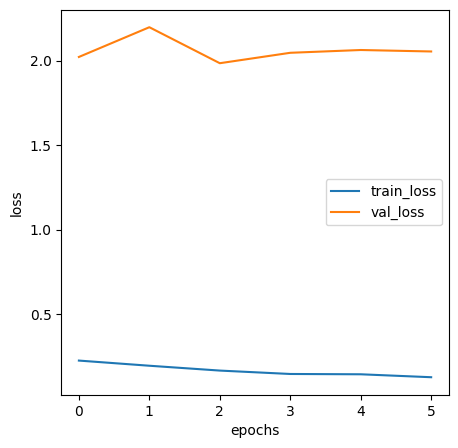

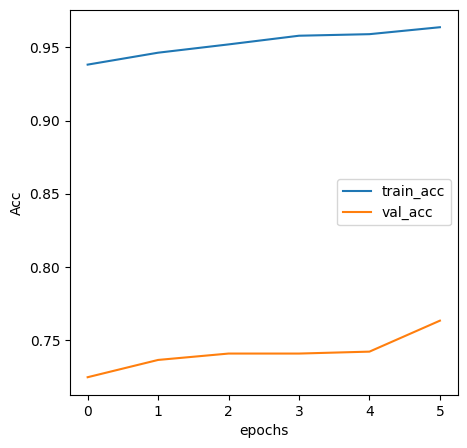

In [80]:
plt.figure(figsize=(5, 5))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()


plt.figure(figsize=(5, 5))
plt.plot(acc, label="train_acc")
# plt.plot(val_acc, label="val_acc")
plt.plot(tuple([i.cpu() for i in val_acc]), label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("Acc")
plt.show()

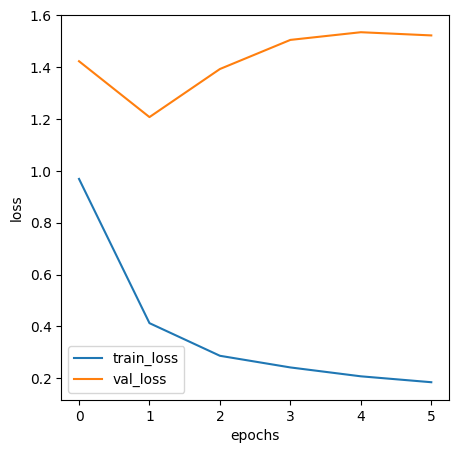

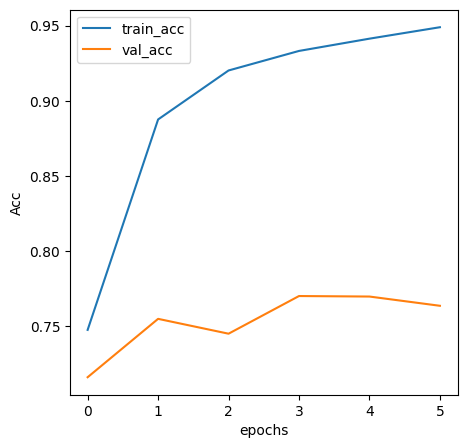

In [634]:
plt.figure(figsize=(5, 5))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()


plt.figure(figsize=(5, 5))
plt.plot(acc, label="train_acc")
# plt.plot(val_acc, label="val_acc")
plt.plot(tuple([i.cpu() for i in val_acc]), label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("Acc")
plt.show()

Формируем прогноз по тестовым данным

In [81]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [82]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [83]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [84]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [85]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Проверяем получившийся скор 

In [ ]:
from sklearn.metrics import f1_score

# f1_score(actual_labels, preds_class)
f1_score(actual_labels, list(y_pred), average='micro')



Выводим примеры тестовых данных и получившихся прогнозов

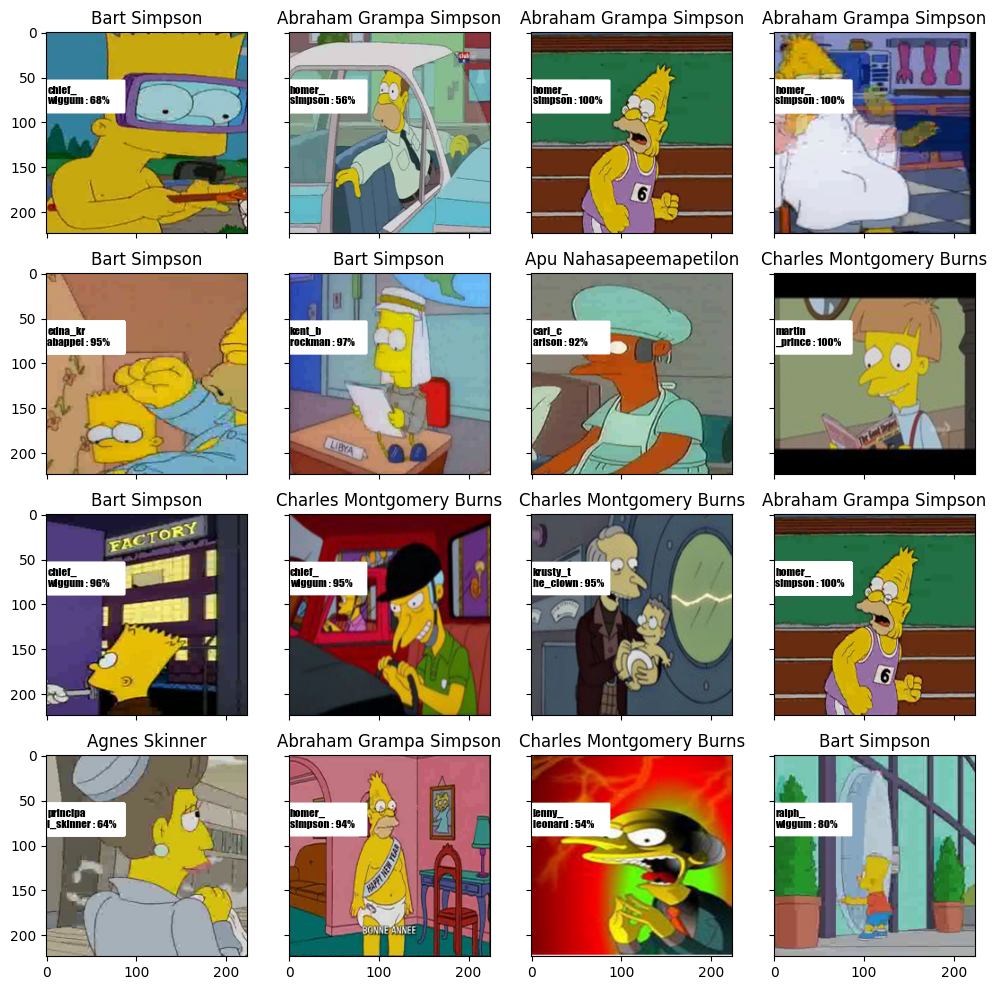

In [213]:
cnt_rows = 4
cnt_cols = 4
fig, ax = plt.subplots(nrows=cnt_rows, ncols=cnt_cols, figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    
    while True:
        random_characters = int(np.random.uniform(0,1000))
        im_val, label = val_dataset[random_characters]
        img_label = " ".join(map(lambda x: x.capitalize(),\
                    val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



        imshow(im_val.data.cpu(), \
              title=img_label,plt_ax=fig_x)

        actual_text = "Actual : {}".format(img_label)

        fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
        font0 = FontProperties()
        font = font0.copy()
        font.set_family("fantasy")
        prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
        predicted_proba = np.max(prob_pred)*100
        y_pred = np.argmax(prob_pred)

        img_src_label = img_label.replace(" ","_").lower()

        predicted_label = label_encoder.classes_[y_pred]
        
        # Пропускаем верно угуданые классы, отображая только ошибочно спрогнозированные
        if predicted_label == img_src_label:
            continue 

        predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
        predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
        fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                        verticalalignment='top',fontsize=8, color='black',fontweight='bold')
        break

### Дальнейшие шаги
- Попробовать модель реснет
- Можно при обучении проверять какие картинки плохо показали точность и для таких картинок делать больше аугментации. Например если у персонажа есть только одно изображение со спины, то в дальнейшем со спины будет тяжелее его определить, аналогично (другая одежда, чб картинка и прочее)


In [103]:
from torchvision import models

def load_basemodel():
    model_extractor = models.resnet50(weights="DEFAULT")
    return model_extractor
model_extractor = load_basemodel()
model_extractor.to(DEVICE)
model_extractor

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [146]:
n_classes = len(np.unique(train_val_labels))
# # замораживаем параметры (веса)
# for name, param in model_extractor.named_parameters():
#     if "layer4" in name:
#         break
#     print(f"name: {name}")
#     param.requires_grad = False
    
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 2048 # У ResNet50 это 2048 фич
# Заменяем Fully-Connected c линейным классификатором, на наше кол-во классов
model_extractor.fc = nn.Linear(num_features, n_classes)
model_extractor.fc.to(DEVICE)

In [166]:
# Высвобождаем память на GPU
import gc
torch.cuda.empty_cache()
gc.collect()
!nvidia-smi
# torch.list_gpu_processes()

Thu Apr 20 08:13:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.94       Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 39%   59C    P8    12W / 151W |   2669MiB /  4096MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [153]:
# Модель РесНет без заморозки слоев
history_resnet = train(train_dataset, val_dataset, model=model_extractor, epochs=4, batch_size=64)

15699
5234


100%|██████████| 1106/1106 [21:21<00:00,  1.16s/it]


loss 0.696178761559797


epoch:  25%|██▌       | 1/4 [26:06<1:18:19, 1566.36s/it]


Epoch 001 train_loss: 0.6962     val_loss 0.8617 train_acc 0.8358 val_acc 0.7927


100%|██████████| 1106/1106 [18:21<00:00,  1.00it/s]


loss 0.3173339476400392


epoch:  50%|█████     | 2/4 [48:12<47:29, 1424.96s/it]  


Epoch 002 train_loss: 0.3173     val_loss 0.8904 train_acc 0.9221 val_acc 0.8001


100%|██████████| 1106/1106 [17:54<00:00,  1.03it/s]


loss 0.24451670172985504


epoch:  75%|███████▌  | 3/4 [1:09:49<22:46, 1366.43s/it]


Epoch 003 train_loss: 0.2445     val_loss 0.8843 train_acc 0.9405 val_acc 0.8034


100%|██████████| 1106/1106 [19:10<00:00,  1.04s/it]


loss 0.20277966904579184


epoch: 100%|██████████| 4/4 [1:32:54<00:00, 1393.64s/it]


Epoch 004 train_loss: 0.2028     val_loss 0.9055 train_acc 0.9500 val_acc 0.8138


In [155]:
loss, acc, val_loss, val_acc = zip(*history_resnet)

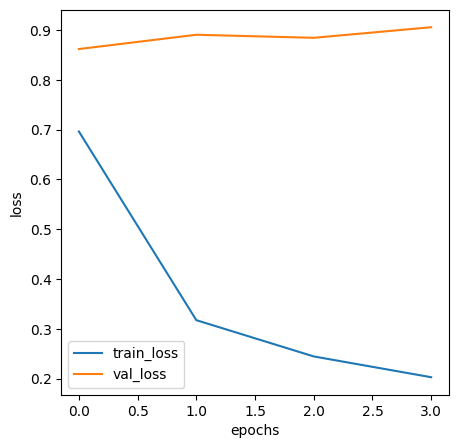

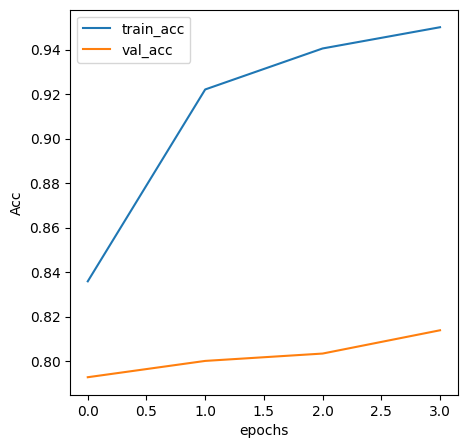

In [156]:
plt.figure(figsize=(5, 5))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()


plt.figure(figsize=(5, 5))
plt.plot(acc, label="train_acc")
# plt.plot(val_acc, label="val_acc")
plt.plot(tuple([i.cpu() for i in val_acc]), label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("Acc")
plt.show()

### Модель РесНет с заморозкой слоев

In [162]:
model_extractor_freeze = load_basemodel()
model_extractor_freeze.to(DEVICE)
model_extractor_freeze

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [164]:
n_classes = len(np.unique(train_val_labels))
# # замораживаем параметры (веса)
for name, param in model_extractor_freeze.named_parameters():
    if "layer4" in name:
        break
    print(f"name: {name}")
    param.requires_grad = False
    
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 2048 # У ResNet50 это 2048 фич
# Заменяем Fully-Connected c линейным классификатором, на наше кол-во классов
model_extractor_freeze.fc = nn.Linear(num_features, n_classes)
model_extractor_freeze.fc.to(DEVICE)

name: conv1.weight
name: bn1.weight
name: bn1.bias
name: layer1.0.conv1.weight
name: layer1.0.bn1.weight
name: layer1.0.bn1.bias
name: layer1.0.conv2.weight
name: layer1.0.bn2.weight
name: layer1.0.bn2.bias
name: layer1.0.conv3.weight
name: layer1.0.bn3.weight
name: layer1.0.bn3.bias
name: layer1.0.downsample.0.weight
name: layer1.0.downsample.1.weight
name: layer1.0.downsample.1.bias
name: layer1.1.conv1.weight
name: layer1.1.bn1.weight
name: layer1.1.bn1.bias
name: layer1.1.conv2.weight
name: layer1.1.bn2.weight
name: layer1.1.bn2.bias
name: layer1.1.conv3.weight
name: layer1.1.bn3.weight
name: layer1.1.bn3.bias
name: layer1.2.conv1.weight
name: layer1.2.bn1.weight
name: layer1.2.bn1.bias
name: layer1.2.conv2.weight
name: layer1.2.bn2.weight
name: layer1.2.bn2.bias
name: layer1.2.conv3.weight
name: layer1.2.bn3.weight
name: layer1.2.bn3.bias
name: layer2.0.conv1.weight
name: layer2.0.bn1.weight
name: layer2.0.bn1.bias
name: layer2.0.conv2.weight
name: layer2.0.bn2.weight
name: layer2

Linear(in_features=2048, out_features=42, bias=True)

In [167]:
# Модель РесНет с заморозкой всех слоев кроме последнего сверточного блока и классификатора
history_resnet_freeze = train(train_dataset, val_dataset, model=model_extractor_freeze, epochs=4, batch_size=64)

15699
5234


100%|██████████| 1106/1106 [19:53<00:00,  1.08s/it]


loss 0.251389321569299


epoch:  25%|██▌       | 1/4 [23:44<1:11:13, 1424.59s/it]


Epoch 001 train_loss: 0.2514     val_loss 0.4860 train_acc 0.9353 val_acc 0.8802


100%|██████████| 1106/1106 [20:15<00:00,  1.10s/it]


loss 0.12983097126287121


epoch:  50%|█████     | 2/4 [47:46<47:49, 1434.71s/it]  


Epoch 002 train_loss: 0.1298     val_loss 0.3829 train_acc 0.9656 val_acc 0.9154


100%|██████████| 1106/1106 [19:42<00:00,  1.07s/it]


loss 0.06121908637833188


epoch:  75%|███████▌  | 3/4 [1:11:13<23:41, 1421.90s/it]


Epoch 003 train_loss: 0.0612     val_loss 0.4568 train_acc 0.9836 val_acc 0.9068


100%|██████████| 1106/1106 [21:58<00:00,  1.19s/it]


loss 0.048794139483334706


epoch: 100%|██████████| 4/4 [1:37:35<00:00, 1463.93s/it]


Epoch 004 train_loss: 0.0488     val_loss 0.4730 train_acc 0.9868 val_acc 0.9060


In [168]:
loss, acc, val_loss, val_acc = zip(*history_resnet_freeze)

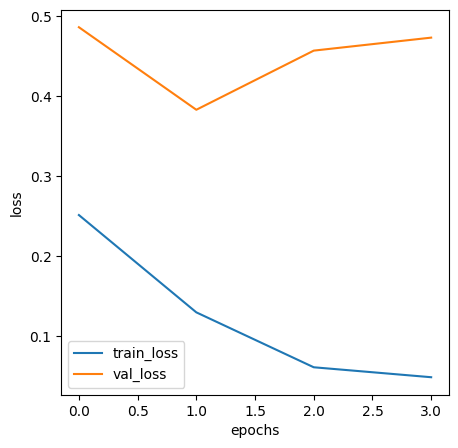

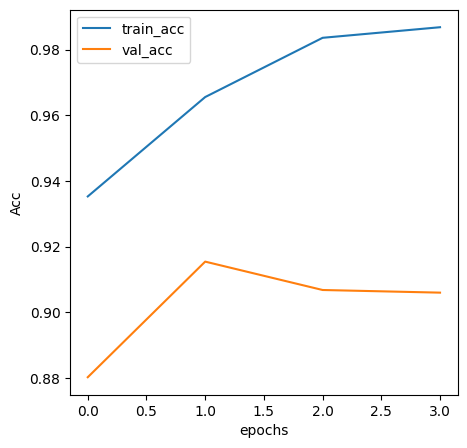

In [169]:
plt.figure(figsize=(5, 5))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()


plt.figure(figsize=(5, 5))
plt.plot(acc, label="train_acc")
# plt.plot(val_acc, label="val_acc")
plt.plot(tuple([i.cpu() for i in val_acc]), label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("Acc")
plt.show()

### Модель РесНет с заморозкой слоев и с регуляризацией

In [175]:
# Переопределяем функцию train добавляя в оптимизатор параметр "weight_decay" для использования L2-регуляризации
def train(train_dataset, val_dataset, model, epochs, batch_size):
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=create_sampler(train_dataset))
    val_loader = DataLoader(val_dataset, batch_size=batch_size, sampler=create_sampler(val_dataset))
    
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), weight_decay=1e-5)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [176]:
model_extractor_freeze_reg = load_basemodel()
model_extractor_freeze_reg.to(DEVICE)
model_extractor_freeze_reg

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [177]:
n_classes = len(np.unique(train_val_labels))
# # замораживаем параметры (веса)
for name, param in model_extractor_freeze_reg.named_parameters():
    if "layer4" in name:
        break
    print(f"name: {name}")
    param.requires_grad = False
    
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 2048 # У ResNet50 это 2048 фич
# Заменяем Fully-Connected c линейным классификатором, на наше кол-во классов
model_extractor_freeze_reg.fc = nn.Linear(num_features, n_classes)
model_extractor_freeze_reg.fc.to(DEVICE)

name: conv1.weight
name: bn1.weight
name: bn1.bias
name: layer1.0.conv1.weight
name: layer1.0.bn1.weight
name: layer1.0.bn1.bias
name: layer1.0.conv2.weight
name: layer1.0.bn2.weight
name: layer1.0.bn2.bias
name: layer1.0.conv3.weight
name: layer1.0.bn3.weight
name: layer1.0.bn3.bias
name: layer1.0.downsample.0.weight
name: layer1.0.downsample.1.weight
name: layer1.0.downsample.1.bias
name: layer1.1.conv1.weight
name: layer1.1.bn1.weight
name: layer1.1.bn1.bias
name: layer1.1.conv2.weight
name: layer1.1.bn2.weight
name: layer1.1.bn2.bias
name: layer1.1.conv3.weight
name: layer1.1.bn3.weight
name: layer1.1.bn3.bias
name: layer1.2.conv1.weight
name: layer1.2.bn1.weight
name: layer1.2.bn1.bias
name: layer1.2.conv2.weight
name: layer1.2.bn2.weight
name: layer1.2.bn2.bias
name: layer1.2.conv3.weight
name: layer1.2.bn3.weight
name: layer1.2.bn3.bias
name: layer2.0.conv1.weight
name: layer2.0.bn1.weight
name: layer2.0.bn1.bias
name: layer2.0.conv2.weight
name: layer2.0.bn2.weight
name: layer2

Linear(in_features=2048, out_features=42, bias=True)

In [178]:
# Модель РесНет с заморозкой всех слоев кроме последнего сверточного блока и классификатора + регуляризация L2
history_resnet_freeze_reg = train(train_dataset, val_dataset, model=model_extractor_freeze_reg, epochs=4, batch_size=64)

15699
5234


100%|██████████| 1106/1106 [21:42<00:00,  1.18s/it]


loss 0.25334636399915555


epoch:  25%|██▌       | 1/4 [25:29<1:16:27, 1529.08s/it]


Epoch 001 train_loss: 0.2533     val_loss 0.7847 train_acc 0.9339 val_acc 0.8865


100%|██████████| 1106/1106 [20:37<00:00,  1.12s/it]


loss 0.14549881448444013


epoch:  50%|█████     | 2/4 [49:51<49:39, 1489.94s/it]  


Epoch 002 train_loss: 0.1455     val_loss 0.4791 train_acc 0.9617 val_acc 0.8886


100%|██████████| 1106/1106 [19:40<00:00,  1.07s/it]


loss 0.06718957908714121


epoch:  75%|███████▌  | 3/4 [1:13:16<24:11, 1451.20s/it]


Epoch 003 train_loss: 0.0672     val_loss 0.3897 train_acc 0.9816 val_acc 0.9200


100%|██████████| 1106/1106 [19:23<00:00,  1.05s/it]


loss 0.04862832622296302


epoch: 100%|██████████| 4/4 [1:36:18<00:00, 1444.73s/it]


Epoch 004 train_loss: 0.0486     val_loss 0.6345 train_acc 0.9873 val_acc 0.9010


In [211]:
loss, acc, val_loss, val_acc = zip(*history_resnet_freeze_reg)

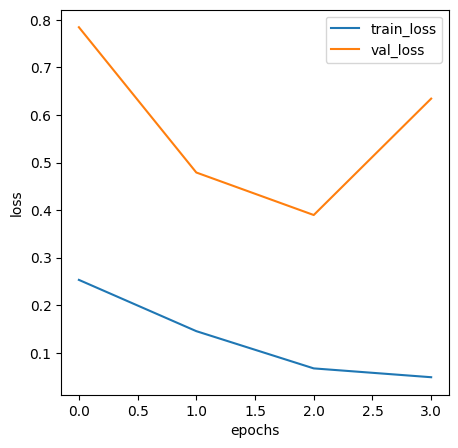

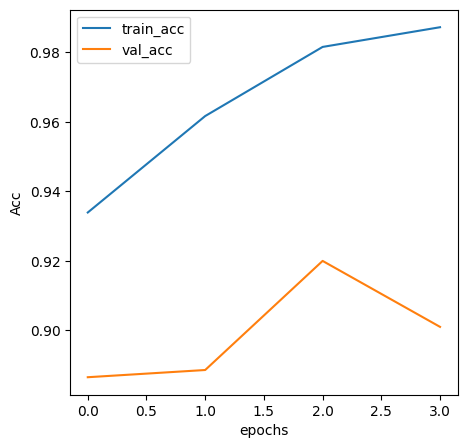

In [212]:
plt.figure(figsize=(5, 5))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()


plt.figure(figsize=(5, 5))
plt.plot(acc, label="train_acc")
# plt.plot(val_acc, label="val_acc")
plt.plot(tuple([i.cpu() for i in val_acc]), label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("Acc")
plt.show()

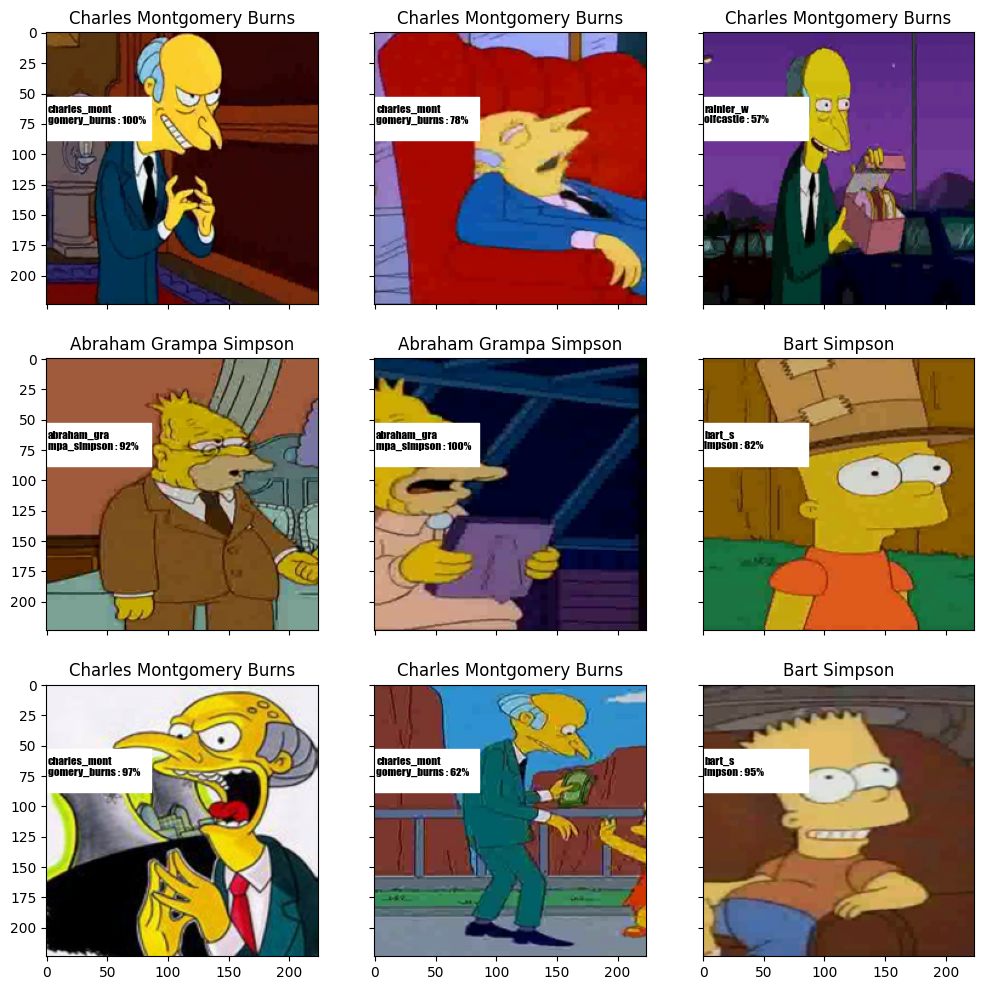

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [642]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [171]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_extractor_freeze, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

Формируем итоговый файл с прогнозом

In [172]:
import pandas as pd
submission_path = PATH + 'sample_submission.csv'
my_submit = pd.read_csv(submission_path)
my_submit.head()

,Id,Expected
0,img0.jpg,bart_simpson
1,img1.jpg,bart_simpson
2,img2.jpg,bart_simpson
3,img3.jpg,bart_simpson
4,img4.jpg,bart_simpson


In [173]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})

In [174]:
my_submit.to_csv(PATH + 'my_submission_model_extractor_freeze_4.csv', index=False)
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


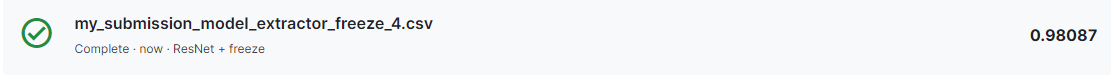